In [65]:
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import mean_squared_error
import numpy as np
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from bs4 import BeautifulSoup
import pandas as pd
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import pearsonr
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ormeiri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def find_symbols(text):
    # Convert to string in case of non-string data (like NaN)
    text = str(text)
    # Regular expression to find non-alphanumeric characters
    symbols = re.findall(r"[^\w\s]", text)
    return symbols

In [4]:
def simple_tokenize(text):
    return text.split()

In [5]:
def preprocess_text(text):
    # Convert to string (in case of NaN or non-string)
    text = str(text)
    # Escape the hyphen or place it at the end of the character set
    cleaned_text = re.sub(r"[^\w\s.,()'\-]", '', text)
    return cleaned_text

In [135]:
def remove_common_words(text):
    return ' '.join([word for word in text.split() if word not in common_words_set])

In [121]:
df = pd.read_csv('/Users/ormeiri/Desktop/Work/sci-search/parser/data/combined_data_new.csv')
df

,term_id,langs,country,term,type,code_lang,hl,gl,Collection date,Result number,...,Is there reference to everyday life?,Is there reference to everyday life? פרופורציה,Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content),Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content)פרופורציה,Does the content present advantages and disadvantages or risks and benefits?,Does the content present advantages and disadvantages or risks and benefits? פרופורציה,ssi_mean,SSI mean פרופורציה Integrated,raw_html,extracted_text
0,70,Zulu,"Cape Town,Western Cape,South Africa",Isikhukhula,Socio-Scientific Issues,zu,zu,za,20.2.2023,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<html>\r\n<head>\r\n<META NAME=""robots"" CONTEN...",NaN
1,71,Zulu,"Cape Town,Western Cape,South Africa",Isomiso,Socio-Scientific Issues,zu,zu,za,20.2.2023,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,\n \n\n\n\n\n\n\n\n\n<!DOCTYPE html>\n<html x...,\ndrought\n
2,71,Zulu,"Cape Town,Western Cape,South Africa",Isomiso,Socio-Scientific Issues,zu,zu,za,20.2.2023,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!doctype html><html lang=""en""><head><script>v...",NaN
3,29,Zulu,"Cape Town,Western Cape,South Africa",Isisindo,Canonical Scientific Issues,zu,zu,za,20.2.2023,11.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!DOCTYPE html><html style=""font-size: 10px;fo...",NaN
4,29,Zulu,"Cape Town,Western Cape,South Africa",Isisindo,Canonical Scientific Issues,zu,zu,za,20.2.2023,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,NaN,"<!DOCTYPE html><html style=""font-size: 10px;fo...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4156,56,Ukrainian,"Kyiv,Kyiv city,Ukraine",калорія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,4.0,...,2.0,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html>\n<html lang=""uk"">\n<head> \n\...",Фітнес портал Калорійність продуктів — як її п...
4157,58,Ukrainian,"Kyiv,Kyiv city,Ukraine",відновлювальна енергія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,2.0,...,2.0,1.0,1.0,0.5,2.0,1.0,0.833333,0.833333,"<!DOCTYPE html><html lang=""uk""><head><meta cha...","Відновлювану енергію можна отримувати з води, ..."
4158,58,Ukrainian,"Kyiv,Kyiv city,Ukraine",відновлювальна енергія,Socio-Scientific Issues,uk,uk,ua,22.12.2022,3.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.000000,1.000000,"<!DOCTYPE html><html style=""font-size: 10px;fo...",NaN
4159,12,Ukrainian,"Kyiv,Kyiv city,Ukraine",гриб,Canonical Scientific Issues,uk,uk,ua,22.12.2022,8.0,...,2.0,1.0,2.0,1.0,2.0,1.0,1.000000,NaN,"<!DOCTYPE html>\n<html xmlns=""http://www.w3.or...",У лісі поблизу Ворохти виявили гігантський біл...


In [123]:
df1 = df[df['Link'] == 'https://physicsworld.com/a/fighting-flat-earth-theory/']
df1

,term_id,langs,country,term,type,code_lang,hl,gl,Collection date,Result number,...,Is there reference to everyday life?,Is there reference to everyday life? פרופורציה,Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content),Are there local examples in the content? (e.g. relevant case study in a country or ethnic group that speaks the language of the content)פרופורציה,Does the content present advantages and disadvantages or risks and benefits?,Does the content present advantages and disadvantages or risks and benefits? פרופורציה,ssi_mean,SSI mean פרופורציה Integrated,raw_html,extracted_text
36,79-B,English,"Washington,District of Columbia,United States",flat earth,Conspiracy Theories,en,en,us,28.6.2022,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"<!DOCTYPE html>\n<html lang=""en-GB"">\n<head>\n...",Sign into your Physics World account to get ac...


In [138]:
# Function to replace entities with tokens
def normalize_text(text):
        # Regex to match dates in various formats
    date_patterns = [
        r'\b\d{1,2}[\/.-]\d{1,2}[\/.-]\d{2,4}\b',  # Matches dates in formats like 19/09/2024, 25.12.2012
        r'\b\d{1,2}\s+(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\s+\d{4}\b',  # Matches dates like 15 Nov 2013, 01 January 2022
        r'\b\d{4}[\/.-]\d{1,2}[\/.-]\d{1,2}\b'  # Matches dates like 2024-09-19
    ]
    # Combine all date regex patterns into one
    date_regex = '|'.join(date_patterns)
    
    text = re.sub(date_regex, '<date>', text)  # Replace dates with <date>
    number_regex = r'\b\d+([.,-]\d+)*[.,]?\b'
    text = re.sub(number_regex, '<number>', text)  # Numbers
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '<url>', text)  # URLs
    text = re.sub(r'\b[\w.-]+?@\w+?\.\w{2,4}\b', '<email>', text)  # Email addresses
    text = re.sub(r'\$\d+(?:\.\d{2})?', '<money>', text)  # Money
    text = re.sub(r'\b\d{3}-\d{4}\b', '<phone>', text)  # Phone numbers
    return text

In [139]:
df['cleaned_text'] = df['extracted_text'].apply(preprocess_text)
df['cleaned_text'] = df['cleaned_text'].apply(normalize_text)
# Find the most common words in the cleaned text
all_words = sum(df['cleaned_text'].apply(simple_tokenize), [])
# Stop words for a few languages
stop_words_set = set()
# Get unique languages from the 'langs' column
unique_langs = df['langs'].unique()  # Add more languages as needed

# Convert to Pandas Series
series_with_nan = pd.Series(unique_langs)

# Removing NaN values
cleaned_series = series_with_nan.dropna()


# Convert back to ndarray if necessary
cleaned_array = cleaned_series.to_numpy()

for lang in cleaned_array:
    try:
        stop_words_set.update(stopwords.words(lang))
    except OSError:
        print(f"No stop words found for '{lang}' in NLTK.")

No stop words found for 'Zulu' in NLTK.
No stop words found for 'Hindi' in NLTK.
No stop words found for 'Taiwanese' in NLTK.
No stop words found for 'Japanese' in NLTK.
No stop words found for 'Afrikaans' in NLTK.
No stop words found for 'Korean' in NLTK.
No stop words found for 'Vietnamese' in NLTK.
No stop words found for 'Swahili' in NLTK.
No stop words found for 'Ukrainian' in NLTK.


In [140]:
# Function to remove stop words and the symbol '-'
def remove_stop_words(words, stop_words):
    return [word for word in words if word not in stop_words and word != '-']

# Removing the stop words
filtered_words = remove_stop_words(all_words, stop_words_set)

In [144]:
word_counts = Counter(filtered_words)
most_common_words = word_counts.most_common(500)
# print(most_common_words)
# Extract just the words from the most_common_words
common_words_set = set([word for word, count in most_common_words])
list_to_remove = ['<number>', 'Apollo']
for word in list_to_remove:
    common_words_set.remove(word)
common_words_set

{'(<number>',
 '(Аполлон-<number>,',
 '(а',
 '(в',
 '(и',
 '(или',
 '(на',
 '(т.е.',
 ')',
 '-<number>',
 '.',
 '<number>)',
 '<number>,',
 '<number>-х',
 '<number>.',
 'A',
 'AS17-<number>,',
 'La',
 'Lunar',
 'Moon',
 'NASA',
 'NASA,',
 'NASA.',
 'The',
 'bir',
 'cho',
 'chất',
 'các',
 'có',
 'của',
 'futhi',
 'không',
 'kwa',
 'là',
 'một',
 'như',
 'những',
 'nấm',
 'thể',
 'trong',
 'van',
 'và',
 'wa',
 'được',
 'А',
 'А,',
 'Адамс',
 'Аполло-<number>',
 'Аполлон',
 'Аполлон-<number>',
 'Аполлон.',
 'Аполлона',
 'Аполлона-<number>',
 'Аполлона-<number>,',
 'Аполлона-<number>.',
 'Аполлонов',
 'Армстронг',
 'Астронавты',
 'В',
 'ВВС',
 'Вот',
 'Впрочем,',
 'Все',
 'Вы',
 'Да',
 'Да,',
 'Действительно,',
 'Для',
 'Дэвид',
 'Его',
 'Если',
 'Земле',
 'Земле,',
 'Земле.',
 'Земли',
 'Земли,',
 'Землю',
 'Земля',
 'И',
 'Из',
 'К',
 'Как',
 'Когда',
 'Кроме',
 'Кстати,',
 'Луна',
 'Луна-<number>',
 'Луне',
 'Луне,',
 'Луне.',
 'Лунный',
 'Луну',
 'Луну,',
 'Луну.',
 'Луны',
 'Луны,',

In [107]:
# Create a combined DataFrame (assuming 'quality_mean', 'accessibility_mean', 'ssi_mean' are columns in df)
combined_df = df[['cleaned_text', 'quality_mean', 'accessibility_mean']]

# Remove rows where any of the target variables are NaN
combined_df = df.dropna(subset=['quality_mean', 'accessibility_mean'])

# Split data into features (X) and target (y)
X = combined_df['cleaned_text']
# Create separate datasets for each target
y_quality = combined_df['quality_mean']
y_accessibility = combined_df['accessibility_mean']

In [108]:
X = X[X != 'nan']
X

1                                             \ndrought\n
5       Isikhala kusuka ku-A kuya ku-Z Ngaphandle kwe-...
6        Nkosikhona Cele  June <number>, <number>  SIT...
8       I-College of Agriculture, Engineering and Scie...
9        Omunye izitsha athandwa kakhulu, okuyinto, ka...
                              ...                        
4155    \nПрирода влаштувала нас так, що, навіть зївши...
4156    Фітнес портал Калорійність продуктів  як її пр...
4157    Відновлювану енергію можна отримувати з води, ...
4159    У лісі поблизу Ворохти виявили гігантський біл...
4160    \nМіцелій білого гриба  це один з найбільш поп...
Name: cleaned_text, Length: 3014, dtype: object

In [110]:
len(X)

3014

In [111]:
y_quality = y_quality[X.index]
y_accessibility = y_accessibility[X.index]
print(len(y_quality))
print(len(y_accessibility))

3014
3014


In [112]:
def train_linear_model(X_train, y_train, X_test):
    pipeline = make_pipeline(TfidfVectorizer(), SelectKBest(f_regression, k=300), LinearRegression())
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    # Clip predictions
    predictions = np.clip(predictions, 0, 1)
    return pipeline, predictions

In [113]:
def train_ridge_model(X_train, y_train, X_test, alpha=1.0):
    pipeline = make_pipeline(TfidfVectorizer(), SelectKBest(f_regression, k=300), Ridge(alpha=alpha))
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    predictions = np.clip(predictions, 0, 1)
    return pipeline, predictions

In [114]:
def train_random_forest_model(X_train, y_train, X_test, n_estimators=100):
    pipeline = make_pipeline(TfidfVectorizer(), SelectKBest(f_regression, k=300), RandomForestRegressor(n_estimators=n_estimators))
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    predictions = np.clip(predictions, 0, 1)
    return pipeline, predictions

In [115]:
def get_linear_feature_importances(pipeline):
    tfidf = pipeline.named_steps['tfidfvectorizer']
    # Try to get the model based on type
    if 'linearregression' in pipeline.named_steps:
        model = pipeline.named_steps['linearregression']
    elif 'ridge' in pipeline.named_steps:
        model = pipeline.named_steps['ridge']
    elif 'lasso' in pipeline.named_steps:
        model = pipeline.named_steps['lasso']
    else:
        raise ValueError("Model not found in pipeline")
    
    feature_names = tfidf.get_feature_names_out()
    coefficients = model.coef_
    return dict(zip(feature_names, coefficients))

def get_random_forest_feature_importances(pipeline):
    tfidf = pipeline.named_steps['tfidfvectorizer']
    model = pipeline.named_steps['randomforestregressor']
    feature_names = tfidf.get_feature_names_out()
    importances = model.feature_importances_
    return dict(zip(feature_names, importances))

In [116]:
def plot_predictions(y_test, predictions, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, alpha=0.5)
    plt.title(title)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # Diagonal line
    plt.show()

MSE for quality_mean with train_linear_model: 0.03609443754303145
Pearson Correlation for accessibility_mean with train_linear_model: 0.2584813465407325


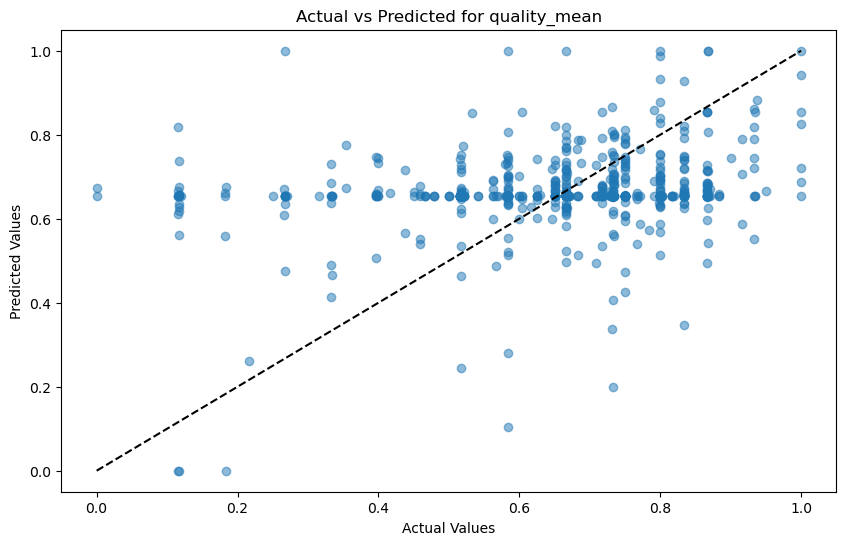

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y_quality, test_size=0.2, random_state=42)
# Train the model
model, predictions = train_linear_model(X_train, y_train, X_test)

# Evaluate the model with MSE
mse = mean_squared_error(y_test, predictions)
print(f"MSE for {y_quality.name} with {train_linear_model.__name__}: {mse}")

# Calculate and print Pearson correlation
correlation, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation for {y.name} with {train_linear_model.__name__}: {correlation}")

# Plot actual vs predicted values
plot_predictions(y_test, predictions, f"Actual vs Predicted for {y_quality.name}")

MSE for quality_mean with train_ridge_model: 0.03357384695956023
Pearson Correlation for accessibility_mean with train_ridge_model: 0.2531964452578603


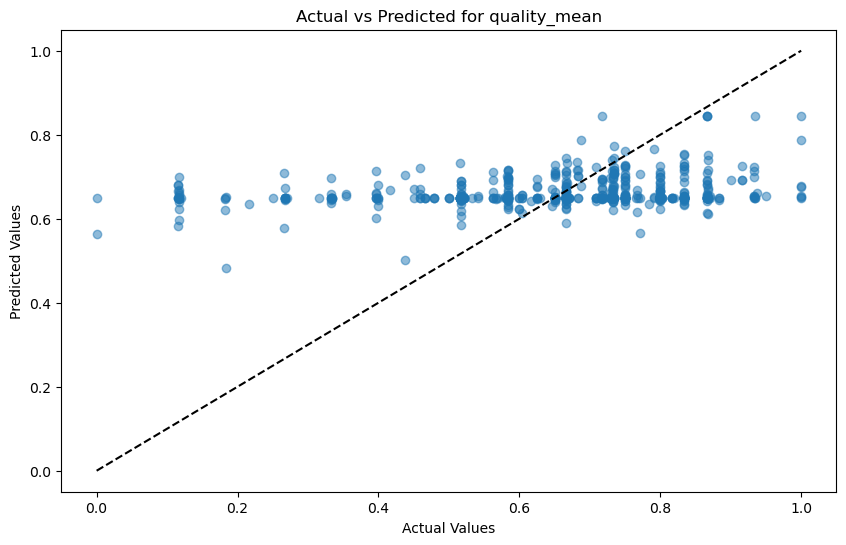

In [118]:
# Train the model
model, predictions = train_ridge_model(X_train, y_train, X_test)

# Evaluate the model with MSE
mse = mean_squared_error(y_test, predictions)
print(f"MSE for {y_quality.name} with {train_ridge_model.__name__}: {mse}")

# Calculate and print Pearson correlation
correlation, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation for {y.name} with {train_ridge_model.__name__}: {correlation}")

# Plot actual vs predicted values
plot_predictions(y_test, predictions, f"Actual vs Predicted for {y_quality.name}")

MSE for quality_mean with train_random_forest_model: 0.03263783039883224
Pearson Correlation for quality_mean with train_random_forest_model: 0.3243117944115564


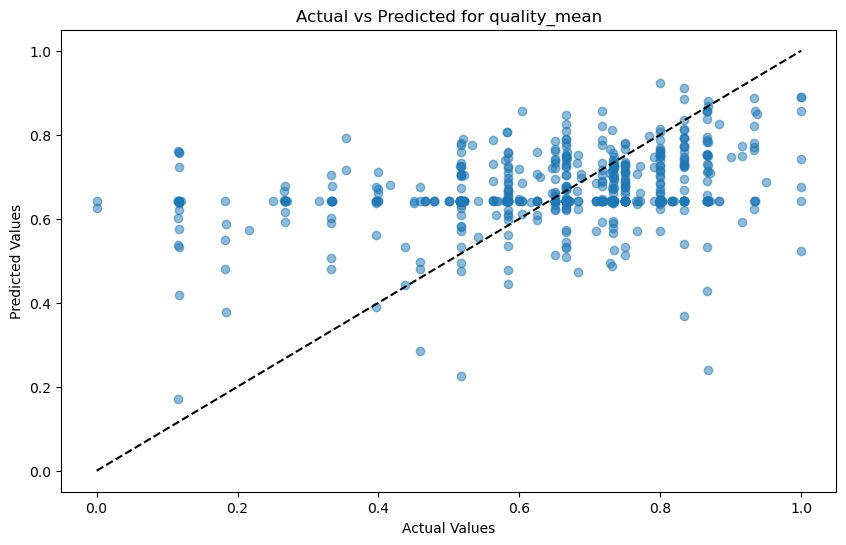

In [120]:
# Train the model
model, predictions = train_random_forest_model(X_train, y_train, X_test)

# Evaluate the model with MSE
mse = mean_squared_error(y_test, predictions)
print(f"MSE for {y_quality.name} with {train_random_forest_model.__name__}: {mse}")

# Calculate and print Pearson correlation
correlation, _ = pearsonr(y_test, predictions)
print(f"Pearson Correlation for {y_quality.name} with {train_random_forest_model.__name__}: {correlation}")

# Plot actual vs predicted values
plot_predictions(y_test, predictions, f"Actual vs Predicted for {y_quality.name}")

In [82]:
# # In your loop, use the appropriate function based on the model type
# for y in [y_quality, y_accessibility]:
#     for model_type in [train_linear_model]:
#         # Split the data
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#         # Train the model
#         model, predictions = model_type(X_train, y_train, X_test)
# 
#         # Evaluate the model with MSE
#         mse = mean_squared_error(y_test, predictions)
#         print(f"MSE for {y.name} with {model_type.__name__}: {mse}")
# 
#         # Calculate and print Pearson correlation
#         correlation, _ = pearsonr(y_test, predictions)
#         print(f"Pearson Correlation for {y.name} with {model_type.__name__}: {correlation}")
# 
#         # Plot actual vs predicted values
#         plot_predictions(y_test, predictions, f"Actual vs Predicted for {y.name}")
        
        # # Get feature importances based on model type
        # if model_type in [train_linear_model, train_ridge_model, train_lasso_model]:
        #     importances = get_linear_feature_importances(model)
        # else:
        #     importances = get_random_forest_feature_importances(model)
        # 
        # sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)
        # print(f"Top 10 influential features for {y.name}: {sorted_importances[:10]}")